# Real-Time Face Mask Detector

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

## Downloading the Dataset

In [2]:
'''
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset
'''

'\n!mkdir -p ~/.kaggle\n!cp kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n!ls ~/.kaggle\n\n!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset\n!unzip face-mask-12k-images-dataset\n'

## Data Preprocessing

In [3]:
dim = (64, 64, 3)
target_size = dim[:2]
epochs = 20

In [4]:
# Generating images for the Training set
datagen = ImageDataGenerator(rescale = 1./255)


# Creating the Training set
training_set = datagen.flow_from_directory('Face Mask Dataset/Train',
                                           target_size = target_size,
                                           batch_size = 10000,
                                           class_mode = 'binary',
                                           shuffle = True)

# Creating the Test set
test_set = datagen.flow_from_directory('Face Mask Dataset/Test',
                                       target_size = target_size,
                                       batch_size = 992,
                                       class_mode = 'binary',
                                       shuffle = False)

# Creating the Validation set
val_set = datagen.flow_from_directory('Face Mask Dataset/Validation',
                                      target_size = target_size,
                                      batch_size = 800,
                                      class_mode = 'binary',
                                      shuffle = False)

Found 10000 images belonging to 2 classes.
Found 992 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
X_train, y_train = training_set.next()

In [6]:
X_test, y_test = test_set.next()

In [7]:
X_val, y_val = val_set.next()

In [8]:
y_train = y_train.reshape((-1,1))
y_val = y_val.reshape((-1,1))
y_test = y_test.reshape((-1,1))

## Displaying Basic Information

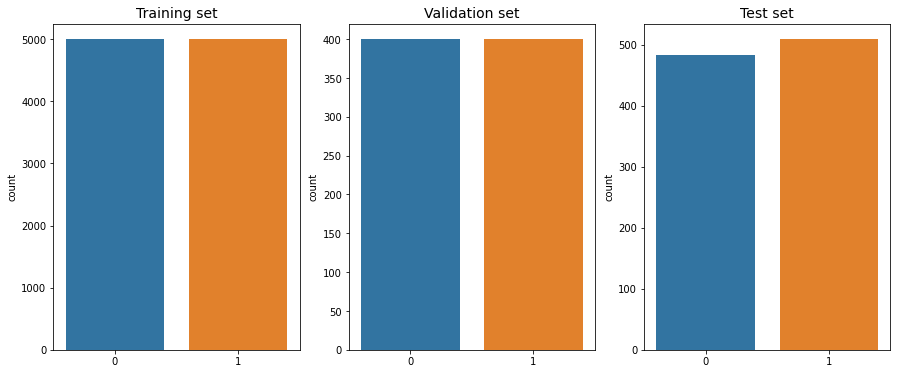

In [9]:
plt.figure(figsize = (15,6))

plt.subplot(1,3,1)
sns.countplot(x = training_set.labels)
plt.title("Training set", size = 14)

plt.subplot(1,3,2)
sns.countplot(x = val_set.labels)
plt.title("Validation set", size = 14)

plt.subplot(1,3,3)
sns.countplot(x = test_set.labels)
plt.title("Test set", size = 14)

plt.show()

In [10]:
print('Image Size (Pixels):', target_size)
print('Color Mode:', training_set.color_mode)
print('Training set:', X_train.shape[0], 'images')
print('Validation set:', X_val.shape[0], 'images')
print('Test set:', X_test.shape[0], 'images')

Image Size (Pixels): (64, 64)
Color Mode: rgb
Training set: 10000 images
Validation set: 800 images
Test set: 992 images


In [11]:
X_val.shape

(800, 64, 64, 3)

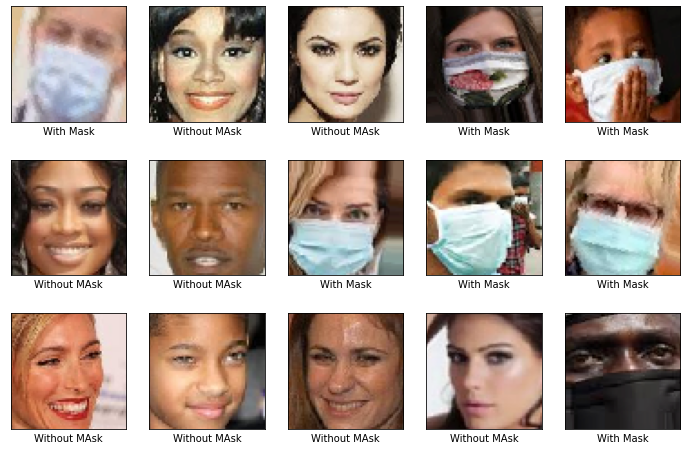

In [12]:
encoding = {1: 'Without MAsk',
            0: 'With Mask'}

plt.figure(figsize=(12, 8))
font = {'size': 10}
plt.rc('font', **font)

j = 1
for i in list(range(15)):
    plt.subplot(3, 5, j)
    plt.xticks([])
    plt.yticks([])
    
    yi = y_train[i][0]
    lbl = encoding[yi]

    plt.xlabel(lbl)
    plt.imshow(X_train[i])

    j += 1
plt.show()

## Using fixed seed

In [13]:
import random
import os

def reset_random_seeds(seed_value=0):
    os.environ['PYTHONHASHSEED']=str(seed_value)
    tf.random.set_seed(seed_value)
    np.random.seed(seed_value)
    random.seed(seed_value)

## Building the CNN

In [20]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


def build_model(epochs=10, batch_size=32, dropout_rate = 0.25, monitor='val_loss', mode='min'):
  # Setting the random seed
  reset_random_seeds(42)

  # Initialising the model
  model = Sequential()

  # Adding a convolutional layer
  model.add(Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=dim))
  model.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))

  # Adding a convolutional layer
  model.add(Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))

  # Adding a convolutional layer
  model.add(Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=2, strides=2, padding='valid'))

  # Flattening
  model.add(Flatten())

  # Full Connection
  model.add(Dense(units=128, activation='relu'))
  model.add(Dropout(dropout_rate))

  # Full Connection
  model.add(Dense(units=64, activation='relu'))
  model.add(Dropout(dropout_rate))

  # Output Layer
  model.add(Dense(units=1, activation='sigmoid'))


  # Training the model
  # Compiling the model
  model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

  # Defining model checkpoint to save the best model
  # Saving the best model
  checkpoint = ModelCheckpoint(filepath = 'SavedModels/model.h5', 
                               monitor=monitor, mode=mode, verbose=1,
                               save_best_only=True, save_weights_only=False)
  
  
  # Training the model on the Training set and evaluating it on the Test set
  history = model.fit(X_train, y_train,
                      epochs = epochs,
                      batch_size=batch_size,
                      validation_data = (X_val, y_val),
                      callbacks=[checkpoint])
  

  return model, history


model, history = build_model(epochs=epochs)

Epoch 1/20
313/313 [==============================] - 3s 7ms/step - loss: 0.1965 - accuracy: 0.9229 - val_loss: 0.1195 - val_accuracy: 0.9675

Epoch 00001: val_loss improved from inf to 0.11948, saving model to SavedModels/model.h5
Epoch 2/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0670 - accuracy: 0.9768 - val_loss: 0.0314 - val_accuracy: 0.9875

Epoch 00002: val_loss improved from 0.11948 to 0.03143, saving model to SavedModels/model.h5
Epoch 3/20
313/313 [==============================] - 2s 7ms/step - loss: 0.0423 - accuracy: 0.9848 - val_loss: 0.0430 - val_accuracy: 0.9812

Epoch 00003: val_loss did not improve from 0.03143
Epoch 4/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0346 - accuracy: 0.9878 - val_loss: 0.0453 - val_accuracy: 0.9850

Epoch 00004: val_loss did not improve from 0.03143
Epoch 5/20
313/313 [==============================] - 2s 6ms/step - loss: 0.0275 - accuracy: 0.9915 - val_loss: 0.0167 - val_accuracy: 0.9937

E

## Visualizing Training History

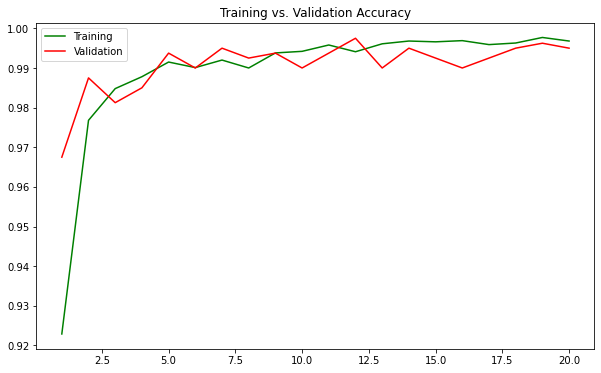

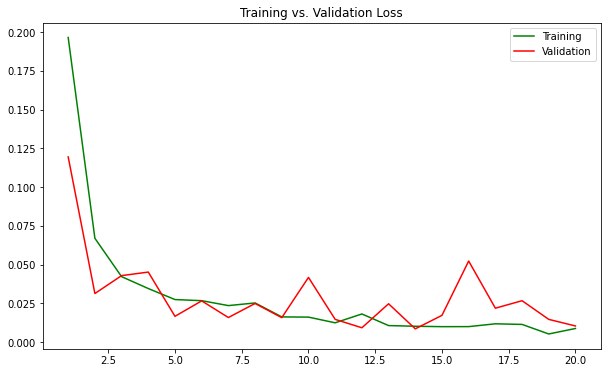

In [21]:
def draw(train, val, title):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(1, epochs+1), 
          train, 
          color = 'green',
          label = "Training")
  
  plt.plot(np.arange(1, epochs+1), 
          val, 
          color = 'red',
          label = "Validation")
  
  plt.legend()
  plt.title(title)
  plt.show()

# Plot accuracy
draw(history.history['accuracy'], 
    history.history['val_accuracy'],
    "Training vs. Validation Accuracy")

# Plot loss
draw(history.history['loss'], 
    history.history['val_loss'],
    "Training vs. Validation Loss")

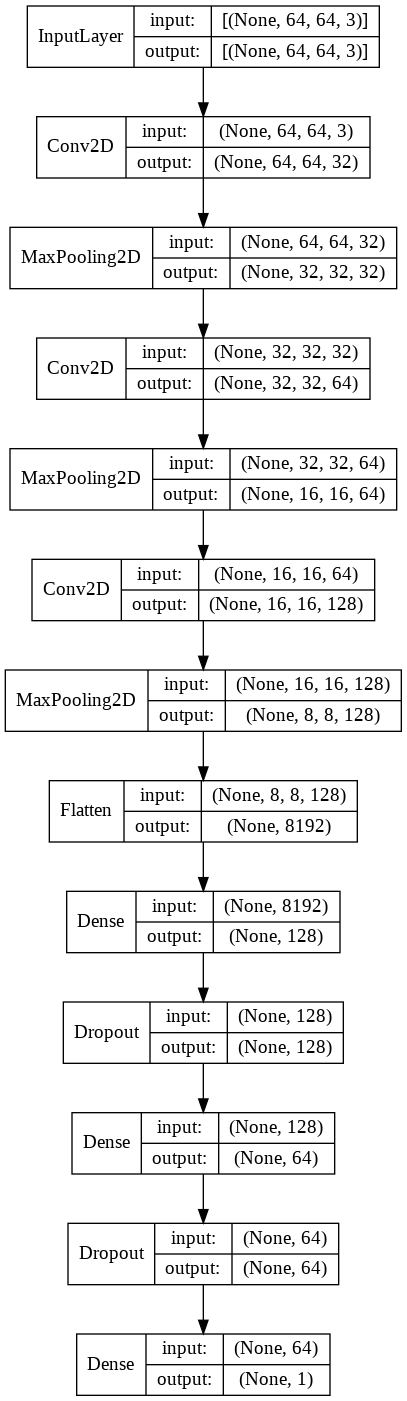

In [22]:
# Plot the model
plot_model(
  model,
  to_file="model.png",
  show_shapes=True,
  show_layer_names=False)

## Loading the Best Model

In [23]:
from keras.models import load_model

model = load_model("/content/SavedModels/model.h5")

## Testing and Model Evaluation

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

# This function plots the confusion matrix and prints accuracy, precision, recall and F1 score
def report(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  acc = np.round(accuracy_score(y_test, y_pred)*100, 2)
  p = np.round(precision_score(y_test, y_pred)*100, 2)
  r = np.round(recall_score(y_test, y_pred)*100, 2)
  f1 = np.round(f1_score(y_test, y_pred)*100, 2)

  data = [acc, p, r, f1]

  idx = ['Accuracy', 'Precision', 'Recall', 'F1']
  results = pd.DataFrame(index=idx, data = data, columns=['Value'])
  results.index.name = 'Metric'
  display(results)

  plt.figure(figsize=(7, 5))
  sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt = 'd', annot_kws={"size": 30}).set_title('Confusion Matrix')
  plt.show()

,Value
Metric,
Accuracy,99.19
Precision,99.21
Recall,99.21
F1,99.21


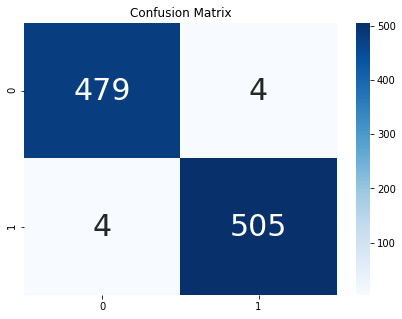

In [25]:
y_pred = model.predict(X_test) > 0.5

report(y_test, y_pred)